In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import numpy as np
from xgboost import XGBRFRegressor
from sklearn.model_selection import train_test_split,cross_val_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,mean_squared_log_error
import statsmodels.api as sm
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

In [3]:
# Load the data
df = pd.read_csv("train.csv")
df.head()

,trip_duration,distance_traveled,num_of_passengers,fare,tip,miscellaneous_fees,total_fare,surge_applied
0,748.0,2.75,1.0,75.00,24,6.300,105.300,0
1,1187.0,3.43,1.0,105.00,24,13.200,142.200,0
2,730.0,3.12,1.0,71.25,0,26.625,97.875,1
3,671.0,5.63,3.0,90.00,0,9.750,99.750,0
4,329.0,2.09,1.0,45.00,12,13.200,70.200,0


- 'trip_duration': How long did the journey last?[in Seconds]

- 'distance_traveled': How far did the taxi travel?[in Km]

- 'num_of_passengers': How many passengers were in the taxi?

- 'fare': What's the base fare for the journey?[In INR]

- 'tip': How much did the driver receive in tips?[In INR]

- 'miscellaneous_fees': Were there any additional charges during the trip?e.g. tolls, convenience fees, GST etc.[In INR]

- 'total_fare': The grand total for the ride (this is your prediction target!).[In INR]

- 'surge_applied': Was there a surge pricing applied? Yes or no?

In [4]:
df.shape

(209673, 8)

In [5]:
# This code checks the type of the train variable
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209673 entries, 0 to 209672
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   trip_duration       209673 non-null  float64
 1   distance_traveled   209673 non-null  float64
 2   num_of_passengers   209673 non-null  float64
 3   fare                209673 non-null  float64
 4   tip                 209673 non-null  int64  
 5   miscellaneous_fees  209673 non-null  float64
 6   total_fare          209673 non-null  float64
 7   surge_applied       209673 non-null  int64  
dtypes: float64(6), int64(2)
memory usage: 12.8 MB


In [6]:
# This code describes the training data
df.describe()

,trip_duration,distance_traveled,num_of_passengers,fare,tip,miscellaneous_fees,total_fare,surge_applied
count,209673.000000,209673.000000,209673.000000,209673.000000,209673.000000,209673.000000,209673.000000,209673.000000
mean,1173.181478,5.054431,1.292808,99.623431,13.030824,15.136829,127.791084,0.280523
std,4775.653621,125.217419,0.930754,85.602702,20.367764,12.553436,98.797374,0.449256
min,0.000000,0.020000,0.000000,0.000000,0.000000,-0.500000,0.000000,0.000000
25%,446.000000,1.950000,1.000000,52.500000,0.000000,6.000000,70.200000,0.000000
50%,707.000000,3.200000,1.000000,75.000000,9.000000,9.750000,101.700000,0.000000
75%,1098.000000,5.730000,1.000000,116.250000,20.000000,26.450000,152.250000,1.000000
max,86387.000000,57283.910000,9.000000,4466.250000,2500.000000,435.000000,4472.250000,1.000000


In [7]:
df.corr()

,trip_duration,distance_traveled,num_of_passengers,fare,tip,miscellaneous_fees,total_fare,surge_applied
trip_duration,1.000000,0.005774,-0.001477,0.150331,0.029132,0.046432,0.142159,0.029961
distance_traveled,0.005774,1.000000,-0.000299,0.035934,0.013487,0.021734,0.036677,0.005567
num_of_passengers,-0.001477,-0.000299,1.000000,0.013224,0.007277,0.010044,0.014234,0.006360
fare,0.150331,0.035934,0.013224,1.000000,0.302044,0.299321,0.966748,0.146687
tip,0.029132,0.013487,0.007277,0.302044,1.000000,0.320919,0.508639,0.239334
miscellaneous_fees,0.046432,0.021734,0.010044,0.299321,0.320919,1.000000,0.452568,0.715497
total_fare,0.142159,0.036677,0.014234,0.966748,0.508639,0.452568,1.000000,0.267350
surge_applied,0.029961,0.005567,0.006360,0.146687,0.239334,0.715497,0.267350,1.000000


In [8]:
df.drop(['total_fare'],axis=1,inplace=True)
df

,trip_duration,distance_traveled,num_of_passengers,fare,tip,miscellaneous_fees,surge_applied
0,748.0,2.75,1.0,75.00,24,6.300,0
1,1187.0,3.43,1.0,105.00,24,13.200,0
2,730.0,3.12,1.0,71.25,0,26.625,1
3,671.0,5.63,3.0,90.00,0,9.750,0
4,329.0,2.09,1.0,45.00,12,13.200,0
...,...,...,...,...,...,...,...
209668,1617.0,8.42,1.0,150.00,47,5.800,0
209669,438.0,1.29,1.0,48.75,12,34.575,1
209670,571.0,2.82,1.0,63.75,0,6.000,0
209671,491.0,2.16,1.0,56.25,0,13.500,0


In [9]:
df.shape

(209673, 7)

In [10]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assuming your DataFrame is named 'df'

# Select all columns for VIF calculation
columns_for_vif = df.columns

# Create a DataFrame to store the VIF results
vif_data = pd.DataFrame()
vif_data['Feature'] = columns_for_vif
vif_data['VIF'] = [variance_inflation_factor(df.values, i) for i in range(len(columns_for_vif))]

# Print the VIF results
print(vif_data)



              Feature       VIF
0       trip_duration  1.084038
1   distance_traveled  1.003149
2   num_of_passengers  1.857478
3                fare  2.521444
4                 tip  1.657926
5  miscellaneous_fees  4.919332
6       surge_applied  2.843864


In [13]:
df = df[df['distance_traveled'] <= 1000]

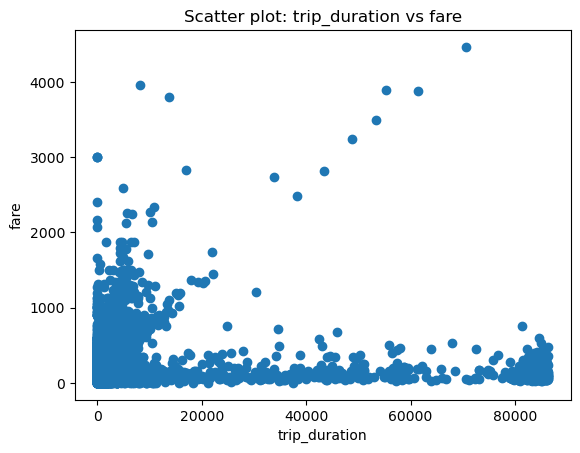

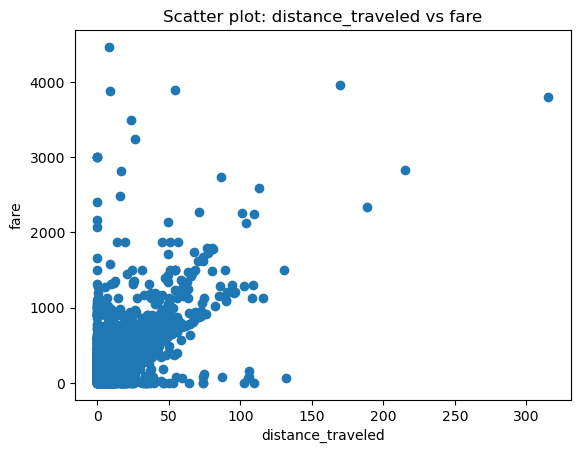

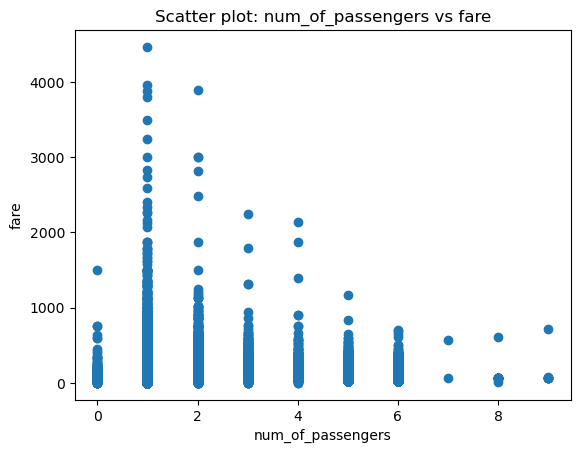

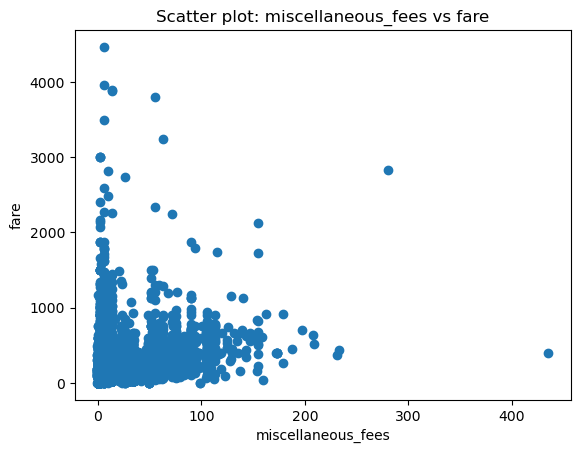

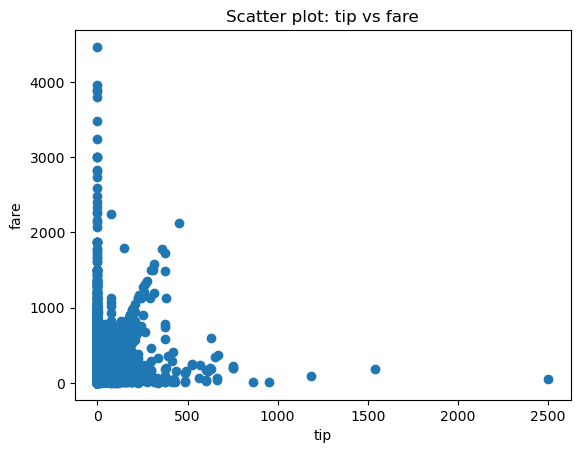

In [14]:
import matplotlib.pyplot as plt

# Select the features for scatter plots
features = ['trip_duration', 'distance_traveled', 'num_of_passengers','miscellaneous_fees','tip']

# Generate scatter plots
for feature in features:
    plt.scatter(df[feature], df['fare'])
    plt.xlabel(feature)
    plt.ylabel('fare')
    plt.title(f'Scatter plot: {feature} vs fare')
    plt.show()


In [11]:
X=df.drop('fare',axis=1)
y=df.fare

Mean Squared Error: 6138.832310890252
R-squared: 0.18056194901753442


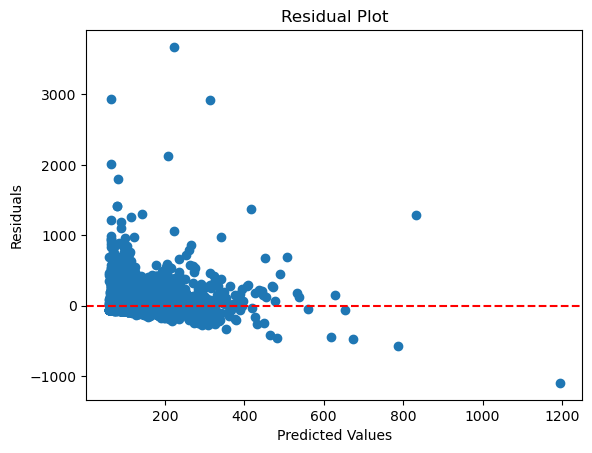

In [12]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Linear Regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
r2 = r2_score(y_test, y_pred)
print('R-squared:', r2)

residuals = y_test - y_pred

# Generate the residual plot
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


In [13]:
coefficients = model.coef_

# Print the coefficients
for i, feature_name in enumerate(X.columns):
    print(f"Coefficient for {feature_name}: {coefficients[i]}")

Coefficient for trip_duration: 0.0023964498967087027
Coefficient for distance_traveled: 0.014221761946485558
Coefficient for num_of_passengers: 0.901426250984638
Coefficient for tip: 0.9233516890998458
Coefficient for miscellaneous_fees: 2.1836716455090825
Coefficient for surge_applied: -26.6941920259388


In [17]:
mape = mean_absolute_percentage_error(y_test, y_pred)
print("Mean Absolute Percentage Error (MAPE):", mape)

Mean Absolute Percentage Error (MAPE): 995279686356860.0


In [124]:
rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
rmsle

0.2936917741725279

In [134]:
model = LinearRegression()

# Perform cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')

# Convert negative mean squared errors to positive
mse_scores = -cv_scores

# Calculate the average mean squared error across folds
avg_mse = mse_scores.mean()

# Print the average mean squared error
print("Average Mean Squared Error:", avg_mse)


Average Mean Squared Error: 2194.525846985925


In [135]:
import pandas as pd
from sklearn.feature_selection import SequentialFeatureSelector, RFE
from sklearn.linear_model import LinearRegression

# Sequential Feature Selection (SFS)
sfs = SequentialFeatureSelector(LinearRegression(), n_features_to_select=3)
X_sfs = sfs.fit_transform(X, y)
selected_features_sfs = X.columns[sfs.get_support(indices=True)].tolist()
print("Selected Features (SFS):", selected_features_sfs)

# Recursive Feature Elimination (RFE)
rfe = RFE(LinearRegression(), n_features_to_select=3)
X_rfe = rfe.fit_transform(X, y)
selected_features_rfe = X.columns[rfe.get_support(indices=True)].tolist()
print("Selected Features (RFE):", selected_features_rfe)


Selected Features (SFS): ['trip_duration', 'distance_traveled', 'tip']
Selected Features (RFE): ['distance_traveled', 'num_of_passengers', 'miscellaneous_fees']


In [137]:
X = df[['trip_duration', 'distance_traveled', 'tip']]
y = df['fare']

model = LinearRegression()

# Perform cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')

# Convert negative mean squared errors to positive
mse_scores = -cv_scores

# Calculate the average mean squared error across folds
avg_mse = mse_scores.mean()

# Print the average mean squared error
print("Average Mean Squared Error:", avg_mse)

Average Mean Squared Error: 2203.179796394802


In [139]:
X = df[['distance_traveled', 'num_of_passengers', 'miscellaneous_fees']]
y = df['fare']

model = LinearRegression()

# Perform cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')

# Convert negative mean squared errors to positive
mse_scores = -cv_scores

# Calculate the average mean squared error across folds
avg_mse = mse_scores.mean()

# Print the average mean squared error
print("Average Mean Squared Error:", avg_mse)

Average Mean Squared Error: 2219.976941145932


In [145]:
import pandas as pd
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Assuming your DataFrame is named 'df' with the relevant columns

# Select the features and target variable
X = df[['trip_duration', 'distance_traveled', 'num_of_passengers', 'tip', 'miscellaneous_fees']]
y = df['fare']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ridge Regression
ridge_model = Ridge(alpha=1.0)  # Specify the regularization strength (alpha)
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)
ridge_mse = mean_squared_error(y_test, y_pred_ridge)
print("Ridge Regression Mean Squared Error:", ridge_mse)

# Lasso Regression
lasso_model = Lasso(alpha=1.0)  # Specify the regularization strength (alpha)
lasso_model.fit(X_train, y_train)
y_pred_lasso = lasso_model.predict(X_test)
lasso_mse = mean_squared_error(y_test, y_pred_lasso)
print("Lasso Regression Mean Squared Error:", lasso_mse)


Ridge Regression Mean Squared Error: 2627.0754954599656
Lasso Regression Mean Squared Error: 2626.654382927261


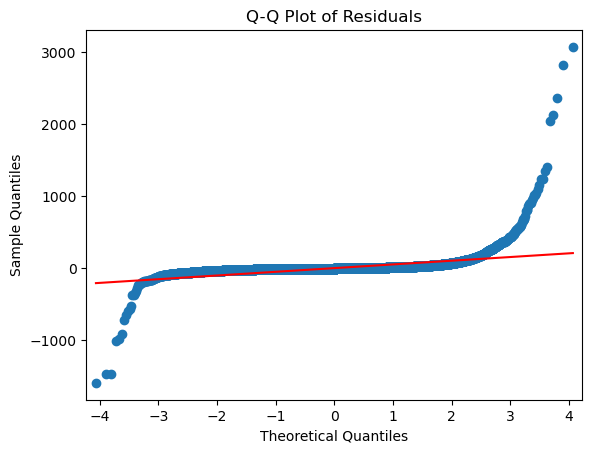

In [154]:
# Generate a Q-Q plot of the residuals
sm.qqplot(residuals, line='s')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.title('Q-Q Plot of Residuals')
plt.show()

In [25]:
import pandas as pd
import statsmodels.api as sm


# Select the features and target variable
X = df[['trip_duration', 'distance_traveled', 'num_of_passengers', 'tip', 'miscellaneous_fees']]
y = df['fare']

# Add a constant to the features
import statsmodels.api as sm

# Add a constant column to the features matrix
X = sm.add_constant(X)

# Create the OLS (Ordinary Least Squares) model
model = sm.OLS(y, X)

# Fit the model
results = model.fit()

# Print the summary statistics
print(results.summary())



                            OLS Regression Results                            
Dep. Variable:                   fare   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                 9.817e+04
Date:                Mon, 19 Jun 2023   Prob (F-statistic):               0.00
Time:                        09:56:56   Log-Likelihood:            -1.1040e+06
No. Observations:              209671   AIC:                         2.208e+06
Df Residuals:                  209665   BIC:                         2.208e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 32.4443      0

In [162]:
y_pred = results.predict(X_test)

# Calculate the Mean Squared Error
mse = mean_squared_error(y_test, y_pred)

print("Mean Squared Error:", mse)

Mean Squared Error: 2855.0787114849854


In [125]:
# Split the data into training set and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

# Define the model
model_fare = XGBRFRegressor()

# Train the model
model_fare.fit(X_train, y_train)

# Predict the validation set results
y_pred_val = model_fare.predict(X_val)

In [131]:
# Calculate the RMSLE
rmsle = np.sqrt(mean_squared_log_error(y_val, y_pred_val))
print(f"Validation RMSLE: {rmsle}")

Validation RMSLE: 0.19554019011255216


In [ ]:
X = df[['trip_duration', 'distance_traveled', 'num_of_passengers', 'tip', 'miscellaneous_fees']]
y = df['fare']

regressor = DecisionTreeRegressor()

# Train the model
regressor.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)